In [1]:
from pycoingecko import CoinGeckoAPI
from datetime import datetime, timezone, timedelta
import numpy as np
import pandas as pd

cg = CoinGeckoAPI()

Timestamp returned by this API are in UTC Timezone.

In [351]:
I = int((datetime(2021,2,16)-datetime(2018, 5, 25)).days/90)

In [353]:
# dt = datetime(2021, 2, 10)
# from_timestamp = dt.replace(tzinfo=timezone.utc).timestamp()

prices_pd_arr = []
dt = datetime(2018, 5, 25)
for i in range(I):
    from_timestamp = dt.replace(tzinfo=timezone.utc).timestamp()

    dt = dt+timedelta(days=+90)
    to_timestamp = dt.replace(tzinfo=timezone.utc).timestamp()

    prices = cg.get_coin_market_chart_range_by_id(id='bitcoin',
                                         vs_currency='USD',
                                         from_timestamp = from_timestamp,
                                         to_timestamp= to_timestamp)
    prices_pd = pd.DataFrame(prices['prices'])
    prices_pd_arr.append(prices_pd)


In [362]:
last_timestamp = datetime(2021,2,17)
last_timestamp = last_timestamp.replace(tzinfo=timezone.utc).timestamp()
prices = cg.get_coin_market_chart_range_by_id(id='bitcoin',
                                     vs_currency='USD',
                                     from_timestamp = to_timestamp,
                                     to_timestamp= last_timestamp)
prices_pd = pd.DataFrame(prices['prices'])
prices_pd_arr.append(prices_pd)

In [454]:
results = pd.concat(prices_pd_arr)
results = results.drop_duplicates()
results.columns = ['UTC_time', 'bitcoin price']

In [455]:
results.loc[:,'UTC_time'] = pd.to_datetime(results.loc[:,'UTC_time']*1000000)
results.loc[:,'berlin_time'] = results.loc[:,'UTC_time'].apply(lambda x: x+timedelta(hours=1))
results.loc[:,'berlin_time_date'] = results.loc[:,'UTC_time'].apply(lambda x: x.date())
results.loc[:,'berlin_time_hour'] = results.berlin_time.apply(lambda x:x.hour)
results.loc[:,'berlin_time_min'] = results.berlin_time.apply(lambda x:x.minute)
results.reset_index(drop=True, inplace=True)

In [468]:
results.to_csv('bitcoin_hourly_price_coingecko_raw.csv')

In [4]:
def time_diff(x, target_hour):
    y = x.year
    m = x.month
    d = x.day 
    return np.abs((x - datetime(y,m,d,target_hour)).total_seconds())

In [5]:
results.loc[:,'D'] = results.berlin_time.apply(lambda x: time_diff(x, 23))

AttributeError: 'str' object has no attribute 'year'

In [2]:
results = pd.read_csv('../data/btc future and reference rate/bitcoin_hourly_price_coingecko_raw.csv')

In [4]:
date_arr = results.berlin_time_date.unique()

closest_to_23 = []

for date in date_arr:
    _id = results.berlin_time_date==date
    closest_to_23.append(np.argmin(results.loc[_id,'D']))

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


In [5]:
bitcoin_price = results.iloc[closest_to_23,:].loc[:,['berlin_time_date', 'bitcoin price']]

In [6]:
bitcoin_price.reset_index(drop=True, inplace=True)

In [7]:
future = pd.read_excel('../data/btc future and reference rate/btc_future.xlsx')
future = future.dropna()

In [8]:
future.Date = pd.to_datetime(future.Date)

In [9]:
bitcoin_price.loc[:,'Date']=pd.to_datetime(bitcoin_price.berlin_time_date)

In [10]:
df = bitcoin_price.merge(future, how='inner', on='Date').loc[:,['Date', 'bitcoin price', 'Close']]
df.dropna(inplace=True)
df.sort_values('Date', ascending= False, inplace=True)
df.reset_index(drop=True, inplace=True)

In [11]:
df.head()

,Date,bitcoin price,Close
0,2021-02-03,37266.377988,37790.0
1,2021-02-02,35615.923864,36535.0
2,2021-02-01,33553.086495,34265.0
3,2021-01-29,34975.625836,35180.0
4,2021-01-28,33194.978393,33085.0


In [12]:
df.loc[:,'log return bitcoin'] =np.log(df.iloc[:,1]/df.iloc[:,1].shift(-1))

In [13]:
df.loc[:,'log return future'] =np.log(df.iloc[:,2]/df.iloc[:,2].shift(-1))


In [14]:
import matplotlib.pyplot as plt
bitcoin = df.loc[:,'log return bitcoin']
bitcoin_future = df.loc[:,'log return future']

plt.scatter(bitcoin,bitcoin_future )

In [15]:
from statsmodels.distributions.empirical_distribution import ECDF

u = ECDF(bitcoin)(bitcoin)
v = ECDF(bitcoin_future)(bitcoin_future)

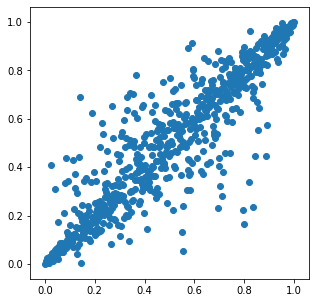

In [16]:
plt.figure(figsize=(5,5))
plt.scatter(u,v)

In [46]:
df.dropna(inplace=True)

In [47]:
df.to_csv('../data/btc future and reference rate/coingecko_future.csv')

In [60]:
df.head()

,Date,bitcoin price,Close,log return bitcoin,log return future
0,2021-02-03,37266.377988,37790.0,0.045299,0.033774
1,2021-02-02,35615.923864,36535.0,0.059664,0.064146
2,2021-02-01,33553.086495,34265.0,-0.041523,-0.026353
3,2021-01-29,34975.625836,35180.0,0.052253,0.061398
4,2021-01-28,33194.978393,33085.0,0.067181,0.036317


In [61]:
import os
filename = 'coingecko_future_v4'
path = "../processed_data/"+ filename+"/"
if not os.path.exists(path):
    os.mkdir(path)
    os.mkdir(path+'train/')
    os.mkdir(path+'test/')
    

In [62]:
step_size = 5
train_size = 500
n = int(np.floor((len(df)-train_size)/step_size))

train_set = []
test_set = []

for i in range(n):
    data = df.iloc[(i*step_size):((i+1)*step_size)+train_size]
    test = data.iloc[:step_size,]
    train = data.iloc[step_size:,]
    train_set.append(train)
    test_set.append(test)

for i in range(len(train_set)):
    train_set[i].to_csv(path+'train/'+str(i)+".csv")
    test_set[i].to_csv(path+'test/'+str(i)+".csv")

https://www.coingecko.com/en/methodology

1. Price (Cryptoasset)
The price of a cryptoasset is calculated based on the pairings available and collected by CoinGecko from the various exchanges for a particular cryptoasset. The price shown on CoinGecko for a particular cryptoasset is calculated using a global volume-weighted average price formula.
Example 1 (Different fiat pairings)

Using Bitcoin (BTC) as an example, and assuming we only track two exchanges, A and B which trades in USD and JPY:

Exchange A: BTC/USD = USD 1,000 / BTC @ 15,000 BTC Trading Volume (rolling 24 hours)
Exchange B: BTC/JPY = JPY 109,000 / BTC @ 10,000 BTC Trading Volume (rolling 24 hours)
CoinGecko will first convert JPY to USD using FX rates provided by OpenExchangeRates. Assuming USD 1 = JPY 110, this will mean:

Exchange B: BTC/JPY = JPY 109,000 / BTC ≈ USD 990 / BTC

CoinGecko will then calculate the global volume-weighted average price. In this case, it will be:

CoinGecko BTC Price (USD)
= [Volume % * USD Price] + [Volume % * Converted USD Price]
= [ 15,000 / (15,000 + 10,000) ] * USD 1,000 + [ 10,000 / (15,000 + 10,000) ] * USD 990
= 0.6 * USD 1,000 + 0.4 * USD 990
= USD 996
Example 2 (Fiat & other crypto pairings)

Using Ethereum (ETH) as an example, and assuming we only track two exchanges, A and B which trades in USD and BTC:
Exchange A: ETH/USD = USD 200 / ETH @ 30,000 ETH Trading Volume (rolling 24 hours)
Exchange B: ETH/BTC = ₿ 0.20000000 / ETH @ 20,000 ETH Trading Volume (rolling 24 hours)
CoinGecko will first convert the ETH/BTC price to a USD price using the CoinGecko BTC Price derived above. Assuming 1 BTC = USD 996, this will mean:
Exchange B: ETH/BTC = ₿ 0.20000000 / ETH ≈ USD 199.2 / ETH

CoinGecko will then calculate the global volume-weighted average price. In this case, it will be:

CoinGecko ETH Price (USD)
= [ 30,000 / (30,000 + 20,000) ] * USD 200 + [ 20,000 / (30,000 + 20,000) ] * USD 199.2
= 0.6 * USD 200 + 0.4 * USD 199.2
= USD 199.68

From Example 1 and 2, the prices obtained in USD are then converted into other local currencies such as GBP, CNY, JPY, EUR and so on using OpenExchangeRates and then displayed on CoinGecko.

Note: CoinGecko’s global volume-weighted average price calculation excludes data points that are detected as outliers as explained in Part 3 below.

